In [1]:
using JLD2
using PythonPlot
include("MDPModelFunctions2.jl")
using DataFrames

    CondaPkg Found dependencies: /Users/erussek/.julia/packages/PythonCall/wXfah/CondaPkg.toml
    CondaPkg Found dependencies: /Users/erussek/.julia/packages/PythonPlot/KcWMF/CondaPkg.toml
    CondaPkg Dependencies already up to date


In [24]:
include("shimi_all_param_search_fine2.jl")

N_Jobs_Total: 1200
N_Runs: 240
Job: 1, N_Quanta: 2, epsilon: 0.99, NT_per_Second: 3200, mem_slope: 0.2


┌ Warning: Assignment to `nt` in soft scope is ambiguous because a global variable by the same name exists: `nt` will be treated as a new local. Disambiguate by using `local nt` to suppress this warning or `global nt` to assign to the existing global variable.
└ @ ~/Dropbox/Griffiths_Lab_Stuff/Code/Memory_Models/shimi_all_param_search_fine2.jl:42
┌ Warning: Assignment to `ms` in soft scope is ambiguous because a global variable by the same name exists: `ms` will be treated as a new local. Disambiguate by using `local ms` to suppress this warning or `global ms` to assign to the existing global variable.
└ @ ~/Dropbox/Griffiths_Lab_Stuff/Code/Memory_Models/shimi_all_param_search_fine2.jl:43


LoadError: LoadError: InterruptException:
in expression starting at /Users/erussek/Dropbox/Griffiths_Lab_Stuff/Code/Memory_Models/shimi_all_param_search_fine2.jl:71

In [25]:
1200/300

4.0

In [2]:
# experiment 1....

# row is 2 obj vs 4 obj
# col is 2 pre-cue, 2 neutral, 2 retro-cue, 2 neutral, 4 pre-cue, 4 neutral, 4 retro-cue, 4 neutral

exp1_cowan_k_true_7_yr = [1.16 1.14 1.13 1.02 2.80 .91 1.30 .96]'
exp1_cowan_k_true_adult = [1.98 1.94 1.97 1.95 3.87 2.66 3.64 2.87]'

# experiment 2 - 4 objects
# col is IM cued, IM neutral, VSTM cued, VSTM neutral

exp2_cowan_k_true_7_yr = [1.55 1.16 1.00 0.69]'
exp2_cowan_k_true_adult = [3.54 2.58 3.58 2.65]'

# experiment 3

# Load 3 cued, Load 3 Neutral, Load 6 cued, Load 6 neutral
IM_true_7_yr = [1.44 1.27 1.82 0.88]
Short_VSTM_true_7_yr = [1.14 0.77 NaN NaN]
Long_VSTM_true_7_yr = [1.19 0.90 NaN NaN]

exp3_cowan_k_true_7_yr = [IM_true_7_yr; Short_VSTM_true_7_yr; Short_VSTM_true_7_yr]


IM_true_adult = [2.63 2.41 4.80 2.46]
Short_VSTM_true_adult = [2.75 2.38 3.97 2.15]
Long_VSTM_true_adult = [2.76 2.30 3.65 1.75]

exp3_cowan_k_true_adult = [IM_true_adult; Short_VSTM_true_adult; Short_VSTM_true_adult]


3×4 Matrix{Float64}:
 2.63  2.41  4.8   2.46
 2.75  2.38  3.97  2.15
 2.75  2.38  3.97  2.15

In [3]:
## Specify parameters for each job and load all results...

eps_vals = collect(.99:-.05:.15) # 17
N_eps = length(eps_vals)

# quanta values
q_vals = collect(2:5:80)
N_q = length(q_vals)

mem_slopes = [.2, .2, .2, .2, .1]
N_ms = length(mem_slopes)

# re-run with new values so we can see some concavity...
NT_vals = [1600, 400, 3200, 800, 800] # run w these now... 
N_nt = length(NT_vals)

N_hyp = N_nt

5

In [6]:

function load_results(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = 2, on_cluster = false)
    
    if on_cluster
        to_save_folder = "/home/erussek/projects/Memory_Models/shimi_all_parameter_search_fine2"
    else
        to_save_folder = "/Users/erussek/Dropbox/Griffiths_Lab_Stuff/code/Memory_Models/shimi_all_parameter_search_fine2/exp$(exp_num)"
    end
    
    local file_name = "N_Quanta_$(N_Quanta)_epsilon_$(epsilon)_NT_per_Second_$(NT_per_Second)_memslope_$(mem_slope).jld2"
    
    local full_file_path = joinpath(to_save_folder,file_name)

    res = load(full_file_path)
    
    return res["job_res_$(exp_num)"]
end

function format_res_cowan_k(res; exp_num = 1)
    
    if exp_num == 1
    
        # row is 2 obj vs 4 obj
        # col is pre-cue, neutral, retro-cue, neutral
        
        part_pcorr = res[:,:,end];
        model_cowan_p_corr = [part_pcorr; part_pcorr[2,:]']'
        model_cowan_k_mtx = cowan_k(model_cowan_p_corr, 2)
        model_cowan_k_mtx[2,:] = cowan_k(model_cowan_p_corr[2,:], 4)
        
        model_cowan_k = [model_cowan_k_mtx[1,:]' model_cowan_k_mtx[2,:]']';#[model_cowan_k_mtx[1,:] model_cowan_k_mtx[2,:]]
    elseif exp_num == 2
        
        # IM cued, IM neutral, VSTM cued, VSTM neutral - need to adjust from what it was saved as
        
        (p_short_neutral, p_short_retro, p_long_neutral, p_long_retro) = res
        (p_short_neutral, p_short_retro, p_long_neutral, p_long_retro) = (p_short_neutral[end], p_short_retro[end], p_long_neutral[end], p_long_retro[end])
        model_cowan_k = cowan_k([p_short_retro p_short_neutral p_long_retro p_long_neutral],4)'
        
    else
        
        (p_IM_neutral, p_IM_retro, p_VSTM_neutral, p_VSTM_retro, p_Long_VSTM_neutral, p_Long_VSTM_retro) = res
        (p_IM_neutral, p_IM_retro, p_VSTM_neutral, p_VSTM_retro, p_Long_VSTM_neutral, p_Long_VSTM_retro) = (p_IM_neutral[:,end], p_IM_retro[:,end], p_VSTM_neutral[:,end], p_VSTM_retro[:,end], p_Long_VSTM_neutral[:,end], p_Long_VSTM_retro[:,end])


        # Load 3 cued, Load 3 Neutral, Load 6 cued, Load 6 neutral
        IM_model = [cowan_k(p_IM_retro[1],3) cowan_k(p_IM_neutral[1],3) cowan_k(p_IM_retro[2],6) cowan_k(p_IM_neutral[2], 6)]
        Short_VSTM_model = [cowan_k(p_VSTM_retro[1],3) cowan_k(p_VSTM_neutral[1],3) cowan_k(p_VSTM_retro[2],6) cowan_k(p_VSTM_neutral[2], 6)]
        Long_VSTM_model = [cowan_k(p_Long_VSTM_retro[1],3) cowan_k(p_Long_VSTM_neutral[1],3) cowan_k(p_Long_VSTM_retro[2],6) cowan_k(p_Long_VSTM_neutral[2], 6)]

        # 3 x 4
        model_cowan_k = [IM_model; Short_VSTM_model; Long_VSTM_model]  
        
    end
        
    return model_cowan_k
    
end    

function load_cowan_k(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = 2, on_cluster = false)
    
    res = load_results(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = exp_num, on_cluster = false)
    
    model_cowan_k = format_res_cowan_k(res; exp_num = exp_num)
    
    return model_cowan_k
    
end


load_cowan_k (generic function with 1 method)

In [8]:
mse_res = Dict()
for exp_num in 1:3
    mse_res[exp_num] = Dict()
    mse_res[exp_num]["child"] = zeros(N_eps, N_q, N_nt)
    mse_res[exp_num]["adult"] = zeros(N_eps, N_q, N_nt)
end

for (ep_idx, epsilon) in enumerate(eps_vals)
    for (q_idx, N_Quanta) in enumerate(q_vals)
        for hyp_idx in 1:length(mem_slopes)
            
            NT_per_Second = NT_vals[hyp_idx]
            mem_slope = mem_slopes[hyp_idx]


            for exp_num = 1:3

                try

                    model_cowan_k = load_cowan_k(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = exp_num, on_cluster = false)

                    if exp_num == 1

                        child_mse = sum((model_cowan_k .- exp1_cowan_k_true_7_yr).^2)
                        adult_mse = sum((model_cowan_k .- exp1_cowan_k_true_adult).^2)

                    elseif exp_num == 2

                        child_mse = sum((model_cowan_k .- exp2_cowan_k_true_7_yr).^2)
                        adult_mse = sum((model_cowan_k .- exp2_cowan_k_true_adult).^2)

                    else

                        child_sq_err = (model_cowan_k[:] .- exp3_cowan_k_true_7_yr[:]).^2
                        child_mse = sum(child_sq_err[.!isnan.(child_sq_err)])
                        adult_mse = sum((model_cowan_k .- exp3_cowan_k_true_adult).^2)

                    end

                    mse_res[exp_num]["child"][ep_idx, q_idx, hyp_idx] = child_mse
                    mse_res[exp_num]["adult"][ep_idx, q_idx, hyp_idx] = adult_mse

                catch

                    print("$(exp_num), $(epsilon), $(N_Quanta), $(NT_per_Second), $(mem_slope)")

                    mse_res[exp_num]["child"][ep_idx, q_idx, hyp_idx] = NaN
                    mse_res[exp_num]["adult"][ep_idx, q_idx, hyp_idx] = NaN

                end

            end

        end
    end
end

# aggregate accross experiments
child_mse_all =  mse_res[1]["child"] + mse_res[2]["child"] + mse_res[3]["child"];
adult_mse_all =  mse_res[1]["adult"] + mse_res[2]["adult"] + mse_res[3]["adult"];

In [10]:
# for child and adult, get the min value and best parameter for each hyperparam

best_mse_child = zeros(N_nt)
best_eps_child = zeros(N_nt)
best_q_child = zeros(N_nt)

best_mse_adult = zeros(N_nt)
best_eps_adult = zeros(N_nt)
best_q_adult = zeros(N_nt)

for hyp_idx = 1:N_nt
        
    this_child_mse = child_mse_all[:,:,hyp_idx]
    best_mse_child[hyp_idx] = minimum(this_child_mse)
    min_idx = argmin(this_child_mse)
    best_eps_child[hyp_idx] = eps_vals[min_idx[1]]
    best_q_child[hyp_idx] = Int(q_vals[min_idx[2]])


    this_adult_mse = adult_mse_all[:,:,hyp_idx]
    best_mse_adult[hyp_idx] = minimum(this_adult_mse)
    min_idx = argmin(this_adult_mse)
    best_eps_adult[hyp_idx] = eps_vals[min_idx[1]]
    best_q_adult[hyp_idx] = Int(q_vals[min_idx[2]])

end

        
best_mse_all = (best_mse_child + best_mse_adult)


5-element Vector{Float64}:
 1.9588116269433056
 2.06442278192347
 1.7048628517638948
 1.9954497366349306
 2.177219198720332

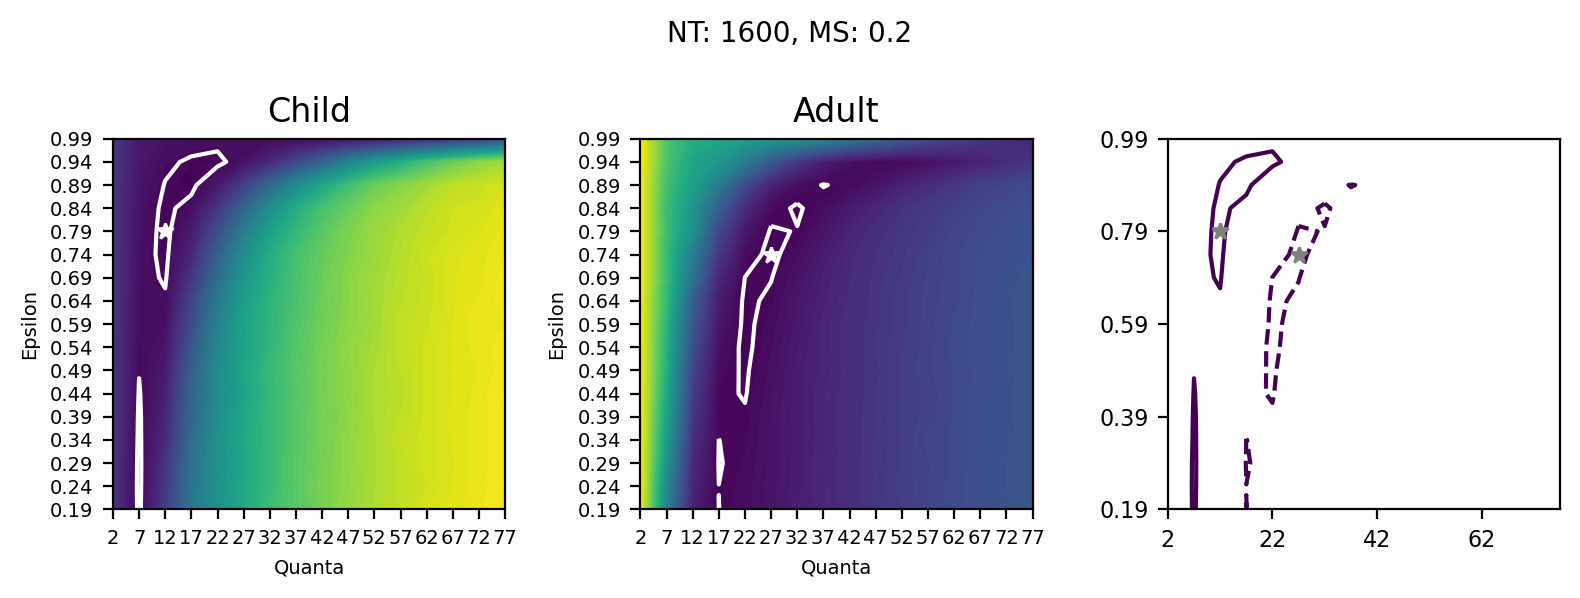

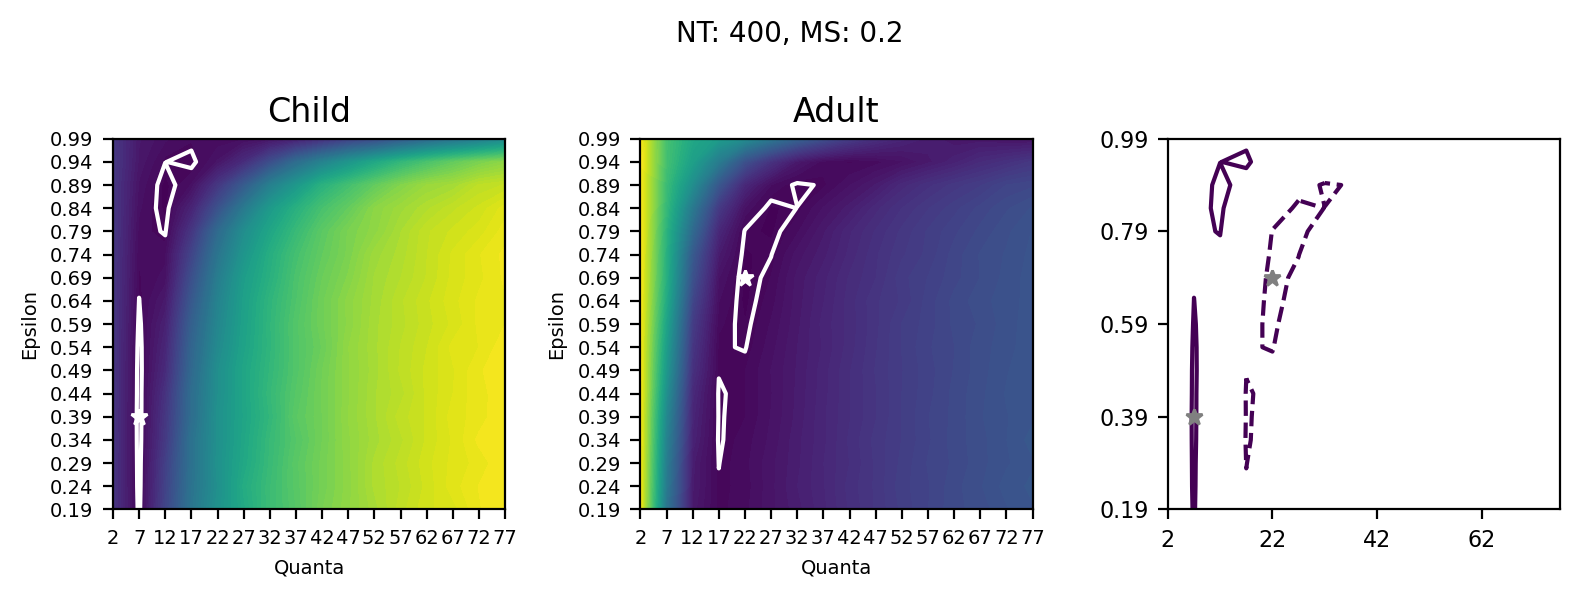

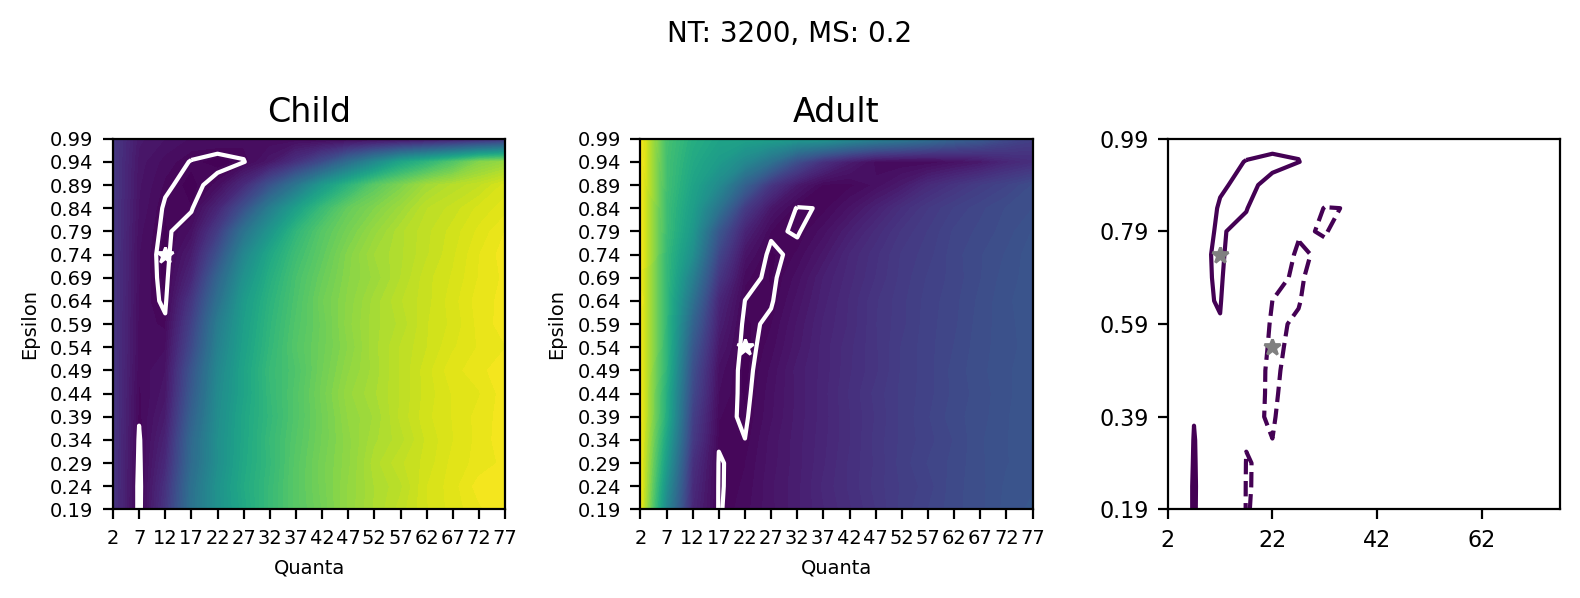

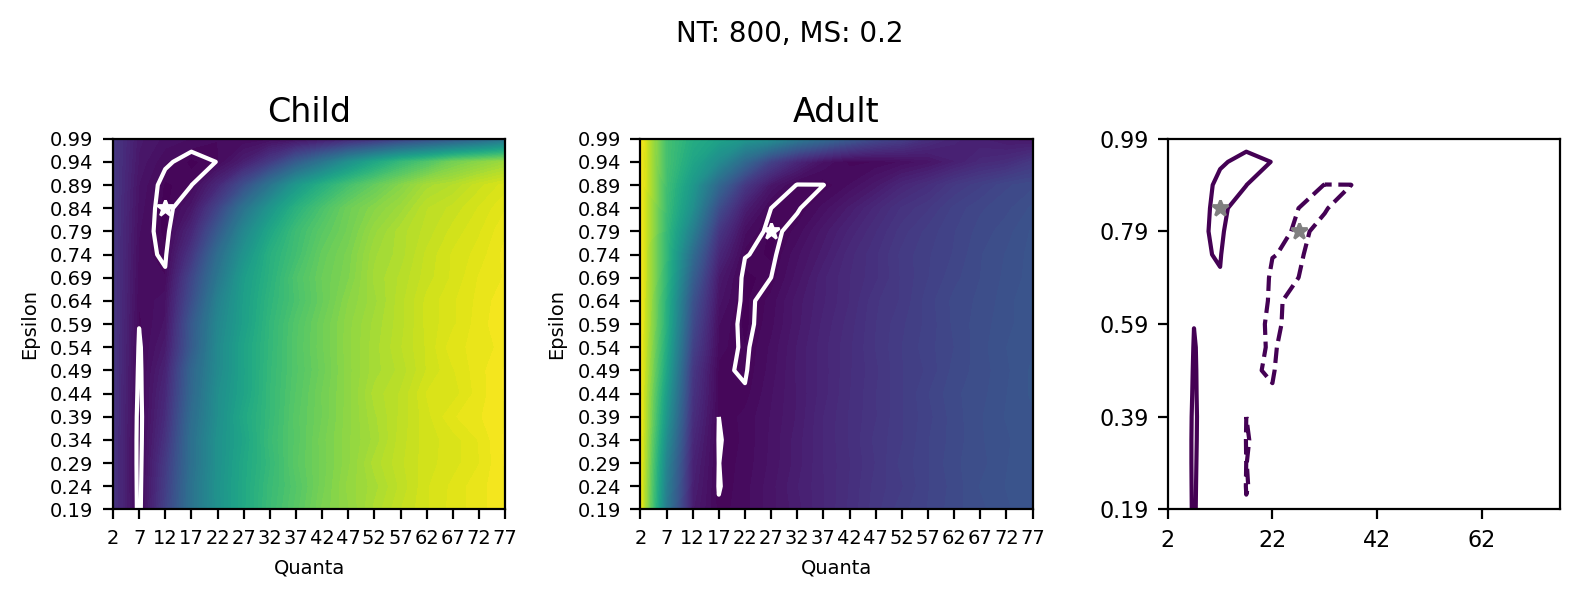

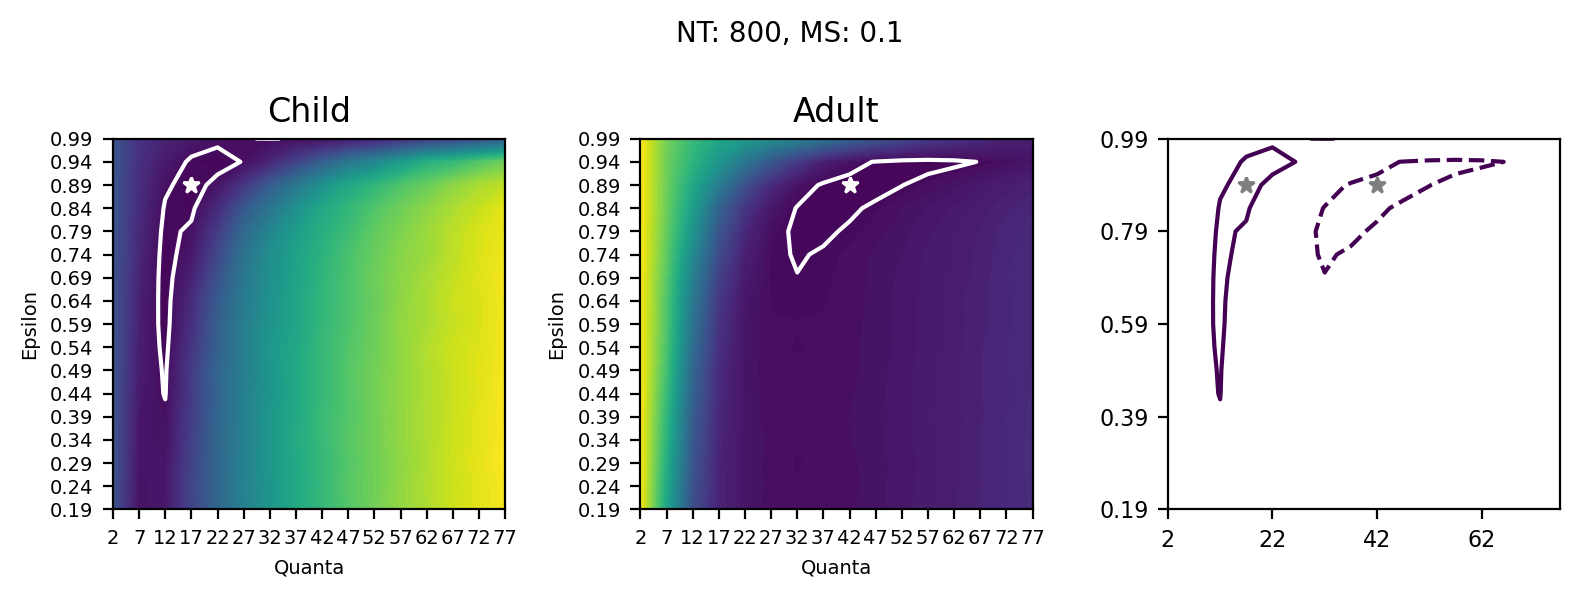

In [22]:
# now for each hyp_idx, plot the mse...
group_ls = ["-", "--"]

for hyp_idx = 1:5

    this_NT = NT_vals[hyp_idx]
    this_ms = mem_slopes[hyp_idx]

    group_names = ["Child", "Adult"]

    fig,ax = subplots(1, 3, figsize=(8,3), dpi= 200, tight_layout=false)

    for group_idx = 0:1
        if group_idx == 0
            this_mse = child_mse_all
        else
            this_mse = adult_mse_all
        end


        ax[group_idx].contourf(this_mse[:, :, hyp_idx], levels = 100)
        this_val_5 = percentile(this_mse[:,:,hyp_idx][:], 5)
        this_val_1 = percentile(this_mse[:,:,hyp_idx][:], 1)


        ax[group_idx].contour(this_mse[:,:,hyp_idx], levels = [this_val_5],  colors = "w")



        ax[group_idx].set_yticks(0:N_eps-1)
        ax[group_idx].set_yticklabels(eps_vals, fontsize=7)
        ax[group_idx].set_ylabel("Epsilon", fontsize=7)

        ax[group_idx].set_xticks(0:N_q-1)
        ax[group_idx].set_xticklabels(q_vals, fontsize=7)
        ax[group_idx].set_xlabel("Quanta", fontsize=7)
        
        ax[group_idx].invert_yaxis()



        # find the minimum index, 
        min_idx = argmin(this_mse[:,:,hyp_idx])

        ax[group_idx].plot(min_idx[2]-1, min_idx[1]-1, '*', color = "white")
        ax[group_idx].set_title(group_names[group_idx+1])
        fig.suptitle("NT: $(this_NT), MS: $(this_ms)", fontsize = 10)
        

        ax[2].contour(this_mse[:,:,hyp_idx], levels = [this_val_5], linestyles = group_ls[group_idx + 1])
        #ax[2].contour(this_mse[:,:,hyp_idx], linestyles = group_ls[group_idx + 1])
        #ax[2].contourf(this_mse[:,:,hyp_idx], linestyles = group_ls[group_idx + 1])


        ax[2].plot(min_idx[2]-1, min_idx[1]-1, '*', color = "gray")

        
    end
    
    ax[2].set_yticks(0:4:(N_eps-1))
    ax[2].set_yticklabels(eps_vals[1:4:end], fontsize=8)
    ax[2].invert_yaxis()
    
    ax[2].set_xticks(0:4:(N_q-1))
    ax[2].set_xticklabels(q_vals[1:4:end], fontsize=8)
    #ax[2].set_aspect("equal", "box")


    
end

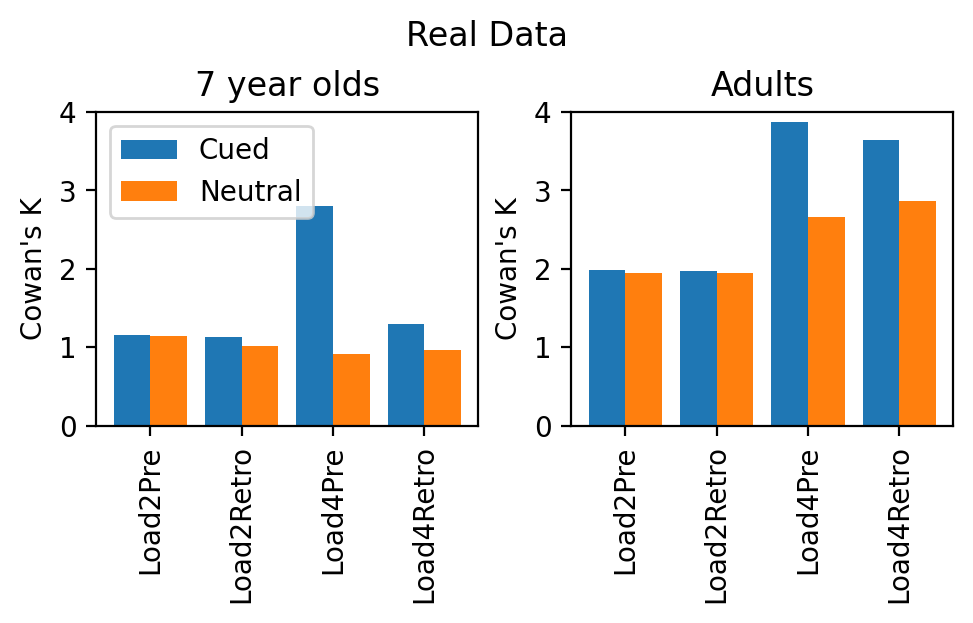

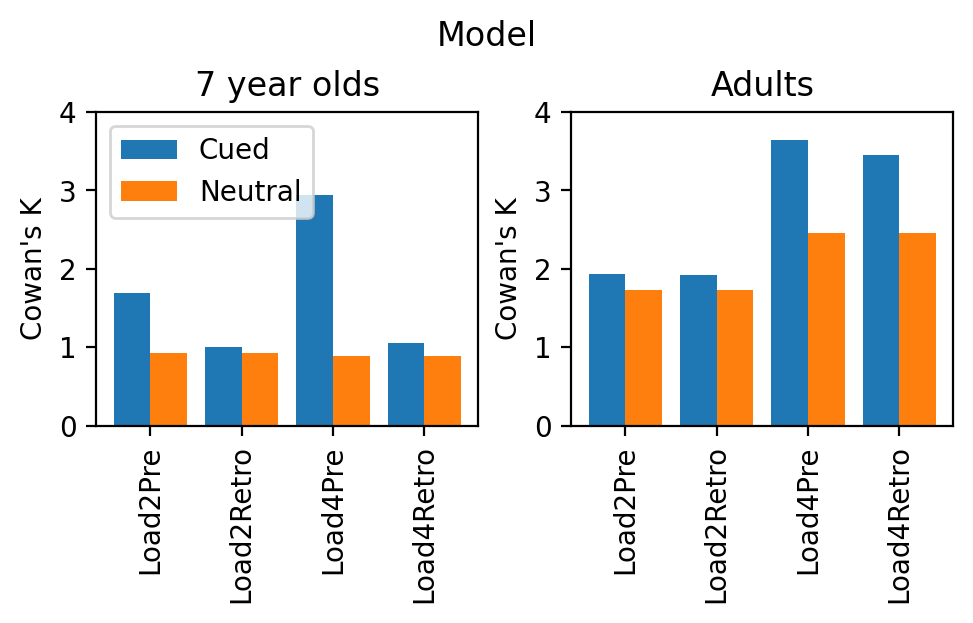

In [14]:
function exp1_plot_cowan_k_bars(this_cowan_k, ax; group_name = "7 year olds")
    x_vals = Vector(1:4) .- .2
    y_vals = [this_cowan_k[[1 3]] this_cowan_k[[5 7]]]
    ax.bar(x_vals, y_vals, .4, label = "Cued")

    x_vals = Vector(1:4) .+ .2
    y_vals = [this_cowan_k[[2 4]] this_cowan_k[[6 8]]]
    ax.bar(x_vals, y_vals, .4, label = "Neutral")
    ax.set_ylim(0,4)

    ax.set_xticks(1:4)
    ax.set_xticklabels(["Load2Pre", "Load2Retro", "Load4Pre", "Load4Retro"], rotation = 90)
    ax.set_title(group_name)
    ax.set_ylabel("Cowan's K")
end

fig,ax = subplots(1, 2,  figsize = (4.75,3), dpi=200,constrained_layout=true, sharey=false)
hyp_idx = 3

ms = mem_slopes[hyp_idx]
nt = NT_vals[hyp_idx]

exp1_plot_cowan_k_bars(exp1_cowan_k_true_7_yr, ax[0])
exp1_plot_cowan_k_bars(exp1_cowan_k_true_adult, ax[1], group_name = "Adults")
ax[0].legend(loc = "upper left")
fig.suptitle("Real Data")

fig,ax = subplots(1, 2,  figsize = (4.75,3), dpi=200,constrained_layout=true, sharey=false)

exp1_cowan_k_model_adult = load_cowan_k(best_eps_adult[hyp_idx], Int(best_q_adult[hyp_idx]), nt,ms; exp_num = 1, on_cluster = false)
exp1_cowan_k_model_7_yr = load_cowan_k(best_eps_child[hyp_idx], Int(best_q_child[hyp_idx]), nt,ms; exp_num = 1, on_cluster = false)

exp1_plot_cowan_k_bars(exp1_cowan_k_model_7_yr, ax[0])
exp1_plot_cowan_k_bars(exp1_cowan_k_model_adult, ax[1], group_name = "Adults")
ax[0].legend(loc = "upper left")
fig.suptitle("Model");


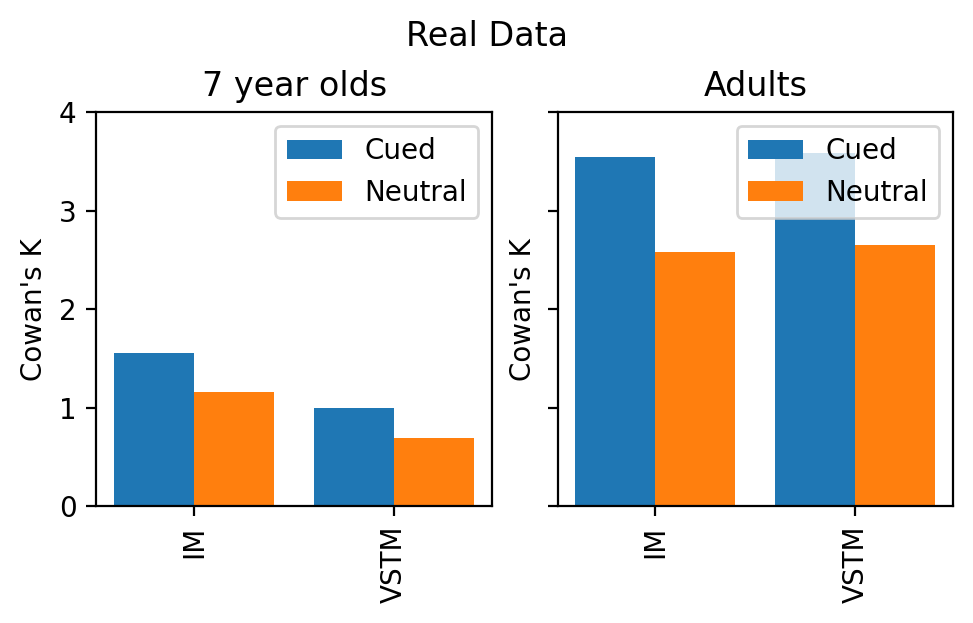

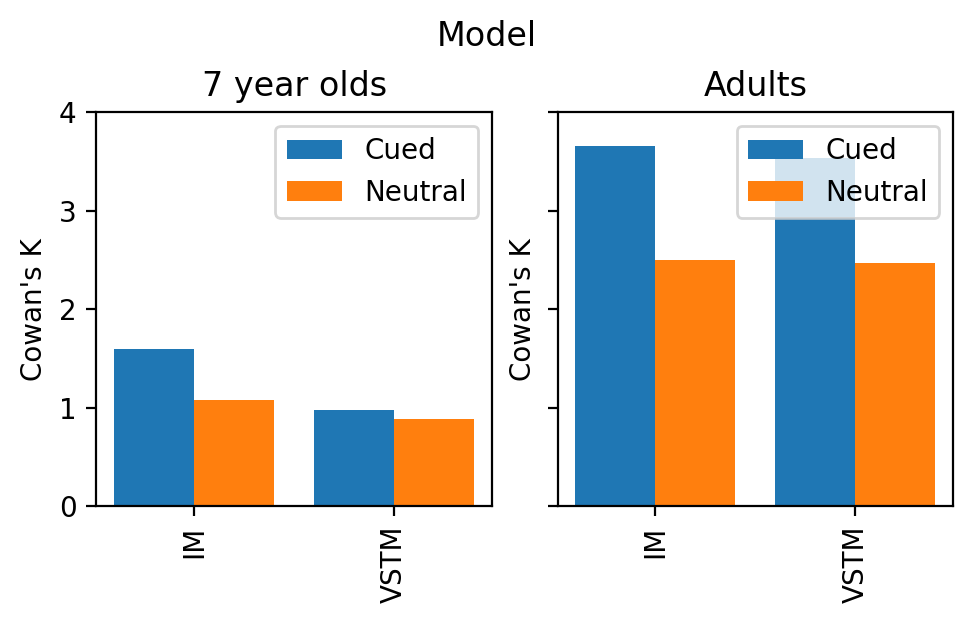

Python: Text(0.5, 0.98611, 'Model')

In [16]:

function exp2_plot_cowan_k_bars(this_cowan_k, ax; group_name = "7 year olds")
    
    x_vals = Vector(1:2) .- .2
    y_vals = this_cowan_k[[1 3]]
    ax.bar(x_vals, y_vals, .4, label = "Cued")

    x_vals = Vector(1:2) .+ .2
    y_vals = this_cowan_k[[2 4]]
    ax.bar(x_vals, y_vals, .4, label = "Neutral")
    ax.set_ylim(0,4)

    ax.legend()

    ax.set_xticks(1:2)
    ax.set_xticklabels(["IM", "VSTM"], rotation = 90)

    ax.set_title(group_name)
    ax.set_ylabel("Cowan's K")
    
end


# neutral performance isn't falling over time at low number of quanta... 
# maybe this reflects 

hyp_idx = 3

ms = mem_slopes[hyp_idx]
nt = NT_vals[hyp_idx]

fig,ax = subplots(1, 2, figsize = (4.75,3), dpi=200,constrained_layout=true, sharey=true)
exp2_plot_cowan_k_bars(exp2_cowan_k_true_7_yr, ax[0])
exp2_plot_cowan_k_bars(exp2_cowan_k_true_adult, ax[1], group_name = "Adults")
fig.suptitle("Real Data")

exp2_cowan_k_model_adult = load_cowan_k(best_eps_adult[hyp_idx], Int(best_q_adult[hyp_idx]), nt,ms; exp_num = 2, on_cluster = false)
exp2_cowan_k_model_7_yr = load_cowan_k(best_eps_child[hyp_idx], Int(best_q_child[hyp_idx]), nt,ms; exp_num = 2, on_cluster = false)

fig,ax = subplots(1, 2, figsize = (4.75,3), dpi=200,constrained_layout=true, sharey=true)

exp2_plot_cowan_k_bars(exp2_cowan_k_model_7_yr, ax[0])
exp2_plot_cowan_k_bars(exp2_cowan_k_model_adult, ax[1], group_name = "Adults")
fig.suptitle("Model")


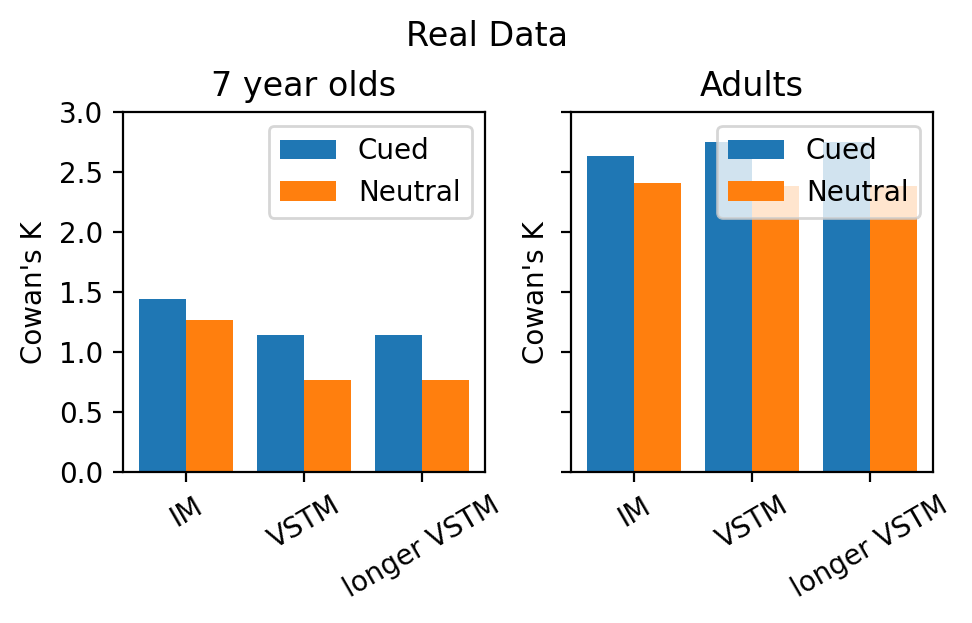

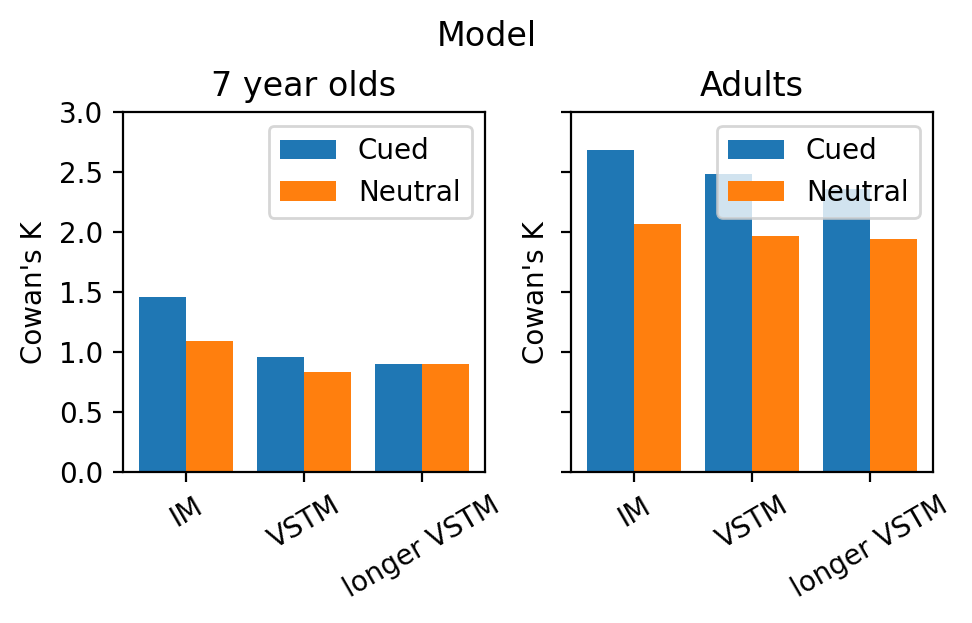

Python: Text(0.5, 0.98611, 'Model')

In [18]:
# this is Cued -  IM, VSTM, Long
function exp3a_plot_cowan_k_bars(this_cowan_k, ax; group_name = "7 year olds")

    cued_cowan_k_load_3 =  this_cowan_k[:,1]
    neutral_cowan_k_load_3 =  this_cowan_k[:,2]


    x_vals = Vector(1:3) .- .2
    y_vals = cued_cowan_k_load_3
    ax.bar(x_vals, y_vals, .4, label = "Cued")

    x_vals = Vector(1:3) .+ .2
    y_vals = neutral_cowan_k_load_3
    ax.bar(x_vals, y_vals, .4, label = "Neutral")

    ax.set_xticks(1:3)

    ax.set_xticklabels(["IM", "VSTM", "longer VSTM"], rotation = 30)

    ax.set_title(group_name)
    ax.set_ylabel("Cowan's K")
    ax.set_ylim(0,3)


    ax.legend()
end

hyp_idx = 3

ms = mem_slopes[hyp_idx]
nt = NT_vals[hyp_idx]

fig,ax = subplots(1, 2, figsize = (4.75,3), dpi=200,constrained_layout=true, sharey=true)
exp3a_plot_cowan_k_bars(exp3_cowan_k_true_7_yr, ax[0])
exp3a_plot_cowan_k_bars(exp3_cowan_k_true_adult, ax[1], group_name = "Adults")
fig.suptitle("Real Data")

exp3a_cowan_k_model_adult = load_cowan_k(best_eps_child[hyp_idx], Int(best_q_adult[hyp_idx]), nt,ms; exp_num = 3, on_cluster = false)
exp3a_cowan_k_model_7_yr = load_cowan_k(best_eps_child[hyp_idx], Int(best_q_child[hyp_idx]), nt,ms; exp_num = 3, on_cluster = false)


fig,ax = subplots(1, 2, figsize = (4.75,3), dpi=200,constrained_layout=true, sharey=true)

exp3a_plot_cowan_k_bars(exp3a_cowan_k_model_7_yr, ax[0])
exp3a_plot_cowan_k_bars(exp3a_cowan_k_model_adult, ax[1], group_name = "Adults")
fig.suptitle("Model")

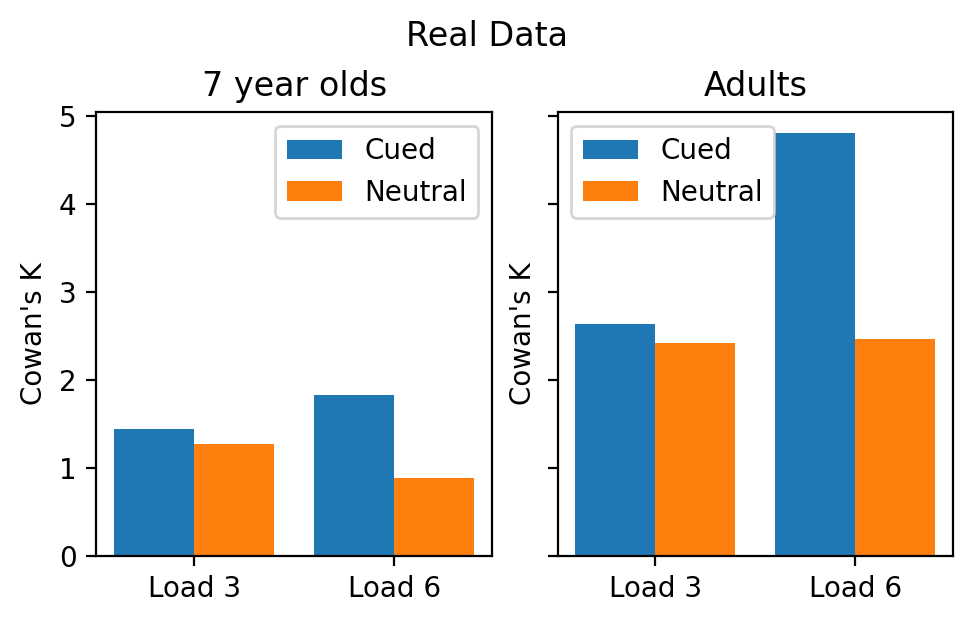

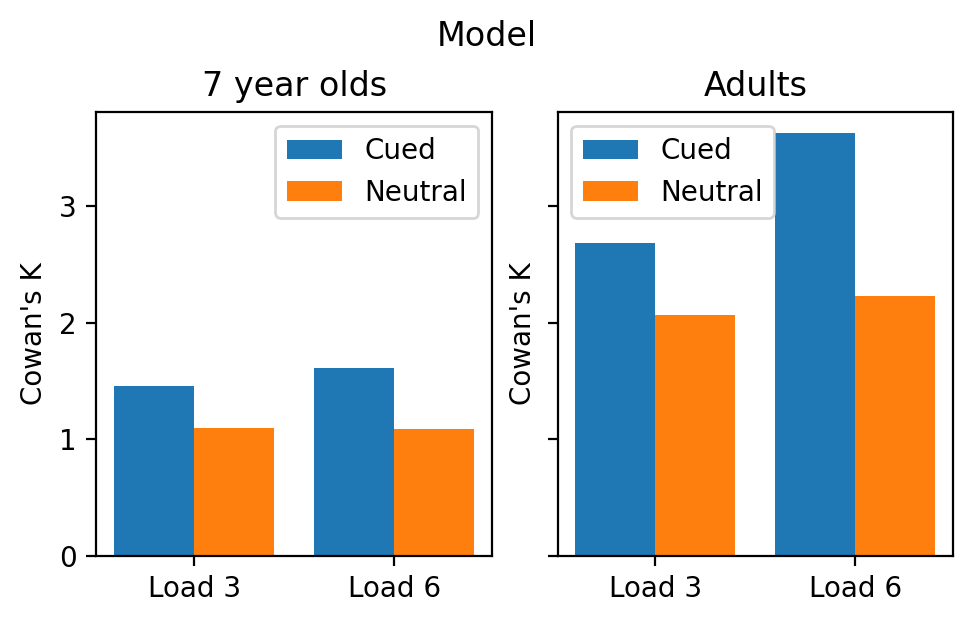

Python: Text(0.5, 0.98611, 'Model')

In [19]:
# next plot... 3b (actually 3c in paper)

# IM

this_cowan_k = exp3_cowan_k_true_7_yr


function exp3b_plot_cowan_k_bars(this_cowan_k, ax; group_name = "7 year olds")

    # Load 3 cued, Load 3 Neutral, Load 6 cued, Load 6 neutral
    cued_cowan_k_IM = this_cowan_k[1,:]

    x_vals = Vector(1:2) .- .2
    y_vals = cued_cowan_k_IM[[1 3]]
    ax.bar(x_vals, y_vals, .4, label = "Cued")

    x_vals = Vector(1:2) .+ .2
    y_vals = cued_cowan_k_IM[[2 4]]
    ax.bar(x_vals, y_vals, .4, label = "Neutral")

    ax.legend()

    ax.set_xticks(1:2)
    ax.set_xticklabels(["Load 3", "Load 6"], rotation = 0)

    ax.set_title(group_name)
    ax.set_ylabel("Cowan's K")
end

# real data
fig,ax = subplots(1, 2, figsize = (4.75,3), dpi=200,constrained_layout=true, sharey=true)
exp3b_plot_cowan_k_bars(exp3_cowan_k_true_7_yr, ax[0])
exp3b_plot_cowan_k_bars(exp3_cowan_k_true_adult, ax[1], group_name = "Adults")
fig.suptitle("Real Data")

# model
#exp3b_cowan_k_model_adult = load_cowan_k(best_params["all"]["adult"]["epsilon"], best_params["all"]["adult"]["N_Quanta"], nt, ms; exp_num = 3, on_cluster = false)
#exp3b_cowan_k_model_7_yr = load_cowan_k(best_params["all"]["child"]["epsilon"], best_params["all"]["child"]["N_Quanta"], nt, ms; exp_num = 3, on_cluster = false)

fig,ax = subplots(1, 2, figsize = (4.75,3), dpi=200,constrained_layout=true, sharey=true)

exp3b_plot_cowan_k_bars(exp3a_cowan_k_model_7_yr, ax[0])
exp3b_plot_cowan_k_bars(exp3a_cowan_k_model_adult, ax[1], group_name = "Adults")
fig.suptitle("Model")


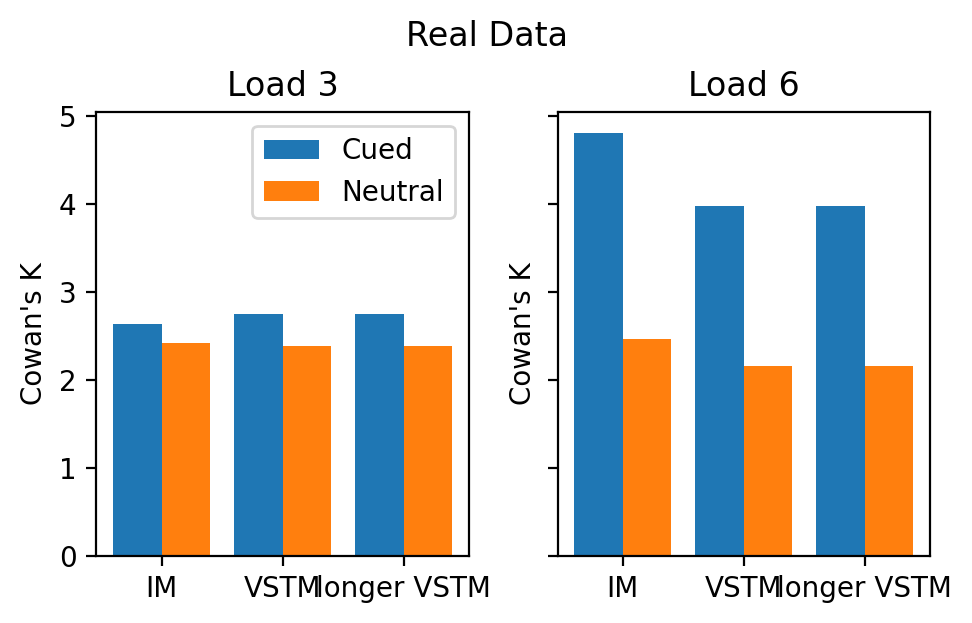

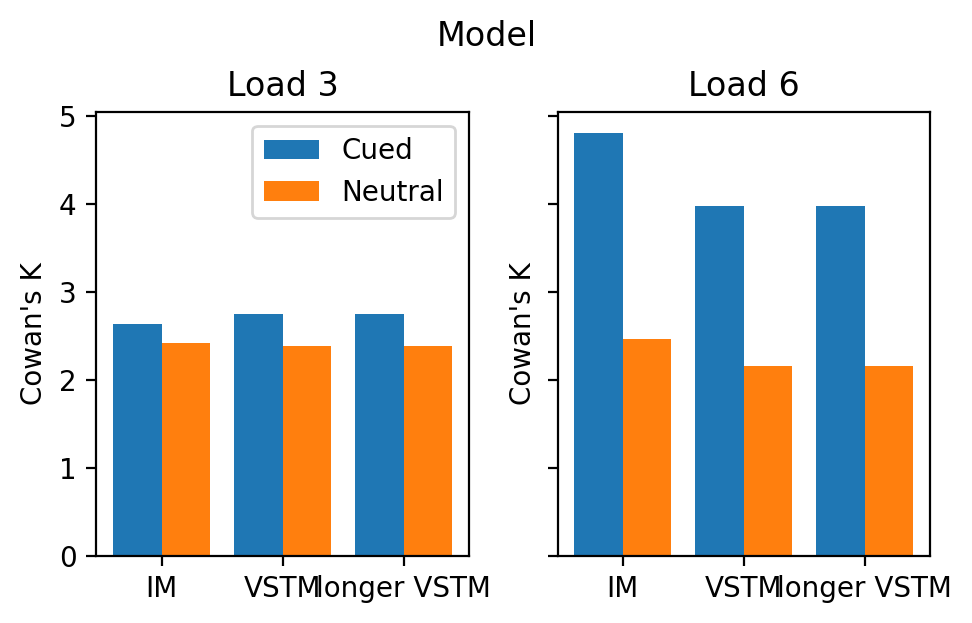

Python: Text(0.5, 0.98611, 'Model')

In [20]:

function exp3c_plot_cowan_k_bars(this_cowan_k, ax; group_name = "7 year olds")

    # one more plot... just adults...

    this_cowan_k = exp3_cowan_k_true_adult
    this_cowan_k
    # Cols: Load 3 cued, Load 3 Neutral, Load 6 cued, Load 6 neutral

    # so first do Load 3 - cued, varying length
    cowan_k_3_cued = this_cowan_k[:,1]
    x_vals = Vector(1:3) .- .2
    y_vals = cowan_k_3_cued
    ax[0].bar(x_vals, y_vals, .4, label = "Cued")

    cowan_k_3_neutral = this_cowan_k[:,2]
    x_vals = Vector(1:3) .+ .2
    y_vals = cowan_k_3_neutral
    ax[0].bar(x_vals, y_vals, .4, label = "Neutral")

    cowan_k_6_cued = this_cowan_k[:,3]
    x_vals = Vector(1:3) .- .2
    y_vals = cowan_k_6_cued
    ax[1].bar(x_vals, y_vals, .4, label = "Cued")

    cowan_k_6_neutral = this_cowan_k[:,4]
    x_vals = Vector(1:3) .+ .2
    y_vals = cowan_k_6_neutral
    ax[1].bar(x_vals, y_vals, .4, label = "Neutral")
    
    ax[0].legend()


    for ax_idx in 0:1
        ax[ax_idx].set_xticks(1:3)
        ax[ax_idx].set_xticklabels(["IM", "VSTM", "longer VSTM"], rotation = 0)
        ax[ax_idx].set_ylabel("Cowan's K")
    end

    ax[0].set_title("Load 3")
    ax[1].set_title("Load 6")

end

fig,ax = subplots(1,2, figsize = (4.75,3), dpi=200,constrained_layout=true, sharey=true)

exp3c_plot_cowan_k_bars(exp3_cowan_k_true_adult, ax)
fig.suptitle("Real Data")
fig,ax = subplots(1,2, figsize = (4.75,3), dpi=200,constrained_layout=true, sharey=true)

exp3c_plot_cowan_k_bars(exp3a_cowan_k_model_adult,ax)
fig.suptitle("Model")
